In [56]:
import torch
from torch import nn

torch.__version__

'2.7.1+cu126'

In [57]:
# Setup device-agnostic code
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [58]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [59]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [60]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [61]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [62]:
# Use ImageFolder to create dataset(s)
import os
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transforms)

NUM_WORKERS = os.cpu_count() # number of workers to use for data loading
assert NUM_WORKERS is not None

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=NUM_WORKERS)   

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [63]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [64]:
from torchinfo import summary
model = TinyVGG(input_shape=3, hidden_units=8, output_shape=3).to(device)
summary(model, input_size=(32, 3, 224, 224), device=device) # batch size of 32, 3 channels (RGB), 224x224 image size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 8, 112, 112]         --
│    └─Conv2d: 2-1                       [32, 8, 224, 224]         224
│    └─ReLU: 2-2                         [32, 8, 224, 224]         --
│    └─Conv2d: 2-3                       [32, 8, 224, 224]         584
│    └─ReLU: 2-4                         [32, 8, 224, 224]         --
│    └─MaxPool2d: 2-5                    [32, 8, 112, 112]         --
├─Sequential: 1-2                        [32, 8, 56, 56]           --
│    └─Conv2d: 2-6                       [32, 8, 112, 112]         584
│    └─ReLU: 2-7                         [32, 8, 112, 112]         --
│    └─Conv2d: 2-8                       [32, 8, 112, 112]         584
│    └─ReLU: 2-9                         [32, 8, 112, 112]         --
│    └─MaxPool2d: 2-10                   [32, 8, 56, 56]           --
├─Sequentia

In [65]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [66]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [67]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [68]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [00:01<01:08,  1.41s/it]

Epoch: 1 | train_loss: 1.1938 | train_acc: 0.3008 | test_loss: 1.2656 | test_acc: 0.1979


  4%|▍         | 2/50 [00:02<00:57,  1.19s/it]

Epoch: 2 | train_loss: 1.1412 | train_acc: 0.3008 | test_loss: 1.0853 | test_acc: 0.5417


  6%|▌         | 3/50 [00:03<00:58,  1.24s/it]

Epoch: 3 | train_loss: 1.1275 | train_acc: 0.3047 | test_loss: 1.1293 | test_acc: 0.1979


  8%|▊         | 4/50 [00:04<00:53,  1.16s/it]

Epoch: 4 | train_loss: 1.0781 | train_acc: 0.4219 | test_loss: 1.0200 | test_acc: 0.5417


 10%|█         | 5/50 [00:05<00:50,  1.13s/it]

Epoch: 5 | train_loss: 1.1540 | train_acc: 0.2812 | test_loss: 1.0685 | test_acc: 0.5625


 12%|█▏        | 6/50 [00:06<00:48,  1.10s/it]

Epoch: 6 | train_loss: 1.0723 | train_acc: 0.4102 | test_loss: 1.2022 | test_acc: 0.1979


 14%|█▍        | 7/50 [00:08<00:47,  1.11s/it]

Epoch: 7 | train_loss: 1.1415 | train_acc: 0.2930 | test_loss: 1.1477 | test_acc: 0.1979


 16%|█▌        | 8/50 [00:09<00:47,  1.12s/it]

Epoch: 8 | train_loss: 1.0790 | train_acc: 0.4453 | test_loss: 1.0792 | test_acc: 0.5739


 18%|█▊        | 9/50 [00:10<00:45,  1.10s/it]

Epoch: 9 | train_loss: 1.0601 | train_acc: 0.4727 | test_loss: 1.0238 | test_acc: 0.5833


 20%|██        | 10/50 [00:11<00:42,  1.07s/it]

Epoch: 10 | train_loss: 1.0906 | train_acc: 0.3516 | test_loss: 0.9801 | test_acc: 0.5028


 22%|██▏       | 11/50 [00:12<00:41,  1.07s/it]

Epoch: 11 | train_loss: 1.0453 | train_acc: 0.5195 | test_loss: 1.1049 | test_acc: 0.4148


 24%|██▍       | 12/50 [00:13<00:41,  1.08s/it]

Epoch: 12 | train_loss: 1.0275 | train_acc: 0.4453 | test_loss: 1.1844 | test_acc: 0.3333


 26%|██▌       | 13/50 [00:14<00:39,  1.06s/it]

Epoch: 13 | train_loss: 0.9532 | train_acc: 0.6211 | test_loss: 1.0041 | test_acc: 0.5350


 28%|██▊       | 14/50 [00:15<00:37,  1.05s/it]

Epoch: 14 | train_loss: 1.0595 | train_acc: 0.3867 | test_loss: 0.9824 | test_acc: 0.5246


 30%|███       | 15/50 [00:16<00:36,  1.05s/it]

Epoch: 15 | train_loss: 0.8869 | train_acc: 0.6211 | test_loss: 1.1027 | test_acc: 0.3731


 32%|███▏      | 16/50 [00:17<00:35,  1.04s/it]

Epoch: 16 | train_loss: 0.9347 | train_acc: 0.4805 | test_loss: 1.0925 | test_acc: 0.4337


 34%|███▍      | 17/50 [00:18<00:34,  1.03s/it]

Epoch: 17 | train_loss: 0.9986 | train_acc: 0.4609 | test_loss: 1.0111 | test_acc: 0.4337


 36%|███▌      | 18/50 [00:19<00:32,  1.03s/it]

Epoch: 18 | train_loss: 0.9907 | train_acc: 0.4766 | test_loss: 0.9640 | test_acc: 0.5436


 38%|███▊      | 19/50 [00:20<00:31,  1.02s/it]

Epoch: 19 | train_loss: 0.9006 | train_acc: 0.6172 | test_loss: 1.0188 | test_acc: 0.4337


 40%|████      | 20/50 [00:21<00:30,  1.00s/it]

Epoch: 20 | train_loss: 0.9050 | train_acc: 0.5000 | test_loss: 0.9587 | test_acc: 0.4631


 42%|████▏     | 21/50 [00:22<00:28,  1.01it/s]

Epoch: 21 | train_loss: 0.7879 | train_acc: 0.6367 | test_loss: 1.0152 | test_acc: 0.3731


 44%|████▍     | 22/50 [00:23<00:27,  1.01it/s]

Epoch: 22 | train_loss: 0.8375 | train_acc: 0.6523 | test_loss: 0.9789 | test_acc: 0.4735


 46%|████▌     | 23/50 [00:24<00:27,  1.02s/it]

Epoch: 23 | train_loss: 0.7971 | train_acc: 0.6328 | test_loss: 0.9414 | test_acc: 0.4640


 48%|████▊     | 24/50 [00:25<00:26,  1.02s/it]

Epoch: 24 | train_loss: 0.7706 | train_acc: 0.6641 | test_loss: 0.9452 | test_acc: 0.5047


 50%|█████     | 25/50 [00:26<00:25,  1.01s/it]

Epoch: 25 | train_loss: 0.8806 | train_acc: 0.6562 | test_loss: 1.0228 | test_acc: 0.3731


 52%|█████▏    | 26/50 [00:27<00:24,  1.01s/it]

Epoch: 26 | train_loss: 0.9497 | train_acc: 0.5156 | test_loss: 1.0662 | test_acc: 0.4347


 54%|█████▍    | 27/50 [00:28<00:23,  1.03s/it]

Epoch: 27 | train_loss: 0.9016 | train_acc: 0.5938 | test_loss: 1.0537 | test_acc: 0.4441


 56%|█████▌    | 28/50 [00:29<00:22,  1.02s/it]

Epoch: 28 | train_loss: 0.7622 | train_acc: 0.6719 | test_loss: 1.0441 | test_acc: 0.4451


 58%|█████▊    | 29/50 [00:30<00:21,  1.03s/it]

Epoch: 29 | train_loss: 0.8236 | train_acc: 0.6719 | test_loss: 1.0361 | test_acc: 0.4555


 60%|██████    | 30/50 [00:31<00:20,  1.04s/it]

Epoch: 30 | train_loss: 0.7569 | train_acc: 0.6680 | test_loss: 1.0297 | test_acc: 0.4337


 62%|██████▏   | 31/50 [00:32<00:19,  1.03s/it]

Epoch: 31 | train_loss: 0.6820 | train_acc: 0.7070 | test_loss: 1.0538 | test_acc: 0.4129


 64%|██████▍   | 32/50 [00:33<00:18,  1.02s/it]

Epoch: 32 | train_loss: 0.7799 | train_acc: 0.7109 | test_loss: 1.0799 | test_acc: 0.3835


 66%|██████▌   | 33/50 [00:34<00:17,  1.00s/it]

Epoch: 33 | train_loss: 0.9133 | train_acc: 0.5000 | test_loss: 1.0109 | test_acc: 0.3845


 68%|██████▊   | 34/50 [00:35<00:16,  1.01s/it]

Epoch: 34 | train_loss: 0.7864 | train_acc: 0.6758 | test_loss: 1.1140 | test_acc: 0.3646


 70%|███████   | 35/50 [00:36<00:15,  1.01s/it]

Epoch: 35 | train_loss: 0.7609 | train_acc: 0.6602 | test_loss: 1.0786 | test_acc: 0.4337


 72%|███████▏  | 36/50 [00:37<00:14,  1.00s/it]

Epoch: 36 | train_loss: 0.7283 | train_acc: 0.6914 | test_loss: 1.0629 | test_acc: 0.4337


 74%|███████▍  | 37/50 [00:38<00:13,  1.00s/it]

Epoch: 37 | train_loss: 0.7504 | train_acc: 0.6914 | test_loss: 1.0264 | test_acc: 0.4545


 76%|███████▌  | 38/50 [00:39<00:11,  1.00it/s]

Epoch: 38 | train_loss: 0.7382 | train_acc: 0.6445 | test_loss: 1.0023 | test_acc: 0.5246


 78%|███████▊  | 39/50 [00:40<00:10,  1.01it/s]

Epoch: 39 | train_loss: 0.7625 | train_acc: 0.5938 | test_loss: 1.0479 | test_acc: 0.4848


 80%|████████  | 40/50 [00:41<00:09,  1.01it/s]

Epoch: 40 | train_loss: 0.7002 | train_acc: 0.7109 | test_loss: 0.9948 | test_acc: 0.4943


 82%|████████▏ | 41/50 [00:42<00:08,  1.01it/s]

Epoch: 41 | train_loss: 0.8460 | train_acc: 0.5977 | test_loss: 1.0128 | test_acc: 0.5057


 84%|████████▍ | 42/50 [00:43<00:08,  1.01s/it]

Epoch: 42 | train_loss: 0.6906 | train_acc: 0.6406 | test_loss: 1.0024 | test_acc: 0.5644


 86%|████████▌ | 43/50 [00:44<00:07,  1.01s/it]

Epoch: 43 | train_loss: 0.6482 | train_acc: 0.7266 | test_loss: 1.1330 | test_acc: 0.3532


 88%|████████▊ | 44/50 [00:45<00:05,  1.00it/s]

Epoch: 44 | train_loss: 1.0164 | train_acc: 0.5898 | test_loss: 1.0625 | test_acc: 0.4536


 90%|█████████ | 45/50 [00:46<00:04,  1.01it/s]

Epoch: 45 | train_loss: 0.8131 | train_acc: 0.7070 | test_loss: 0.9909 | test_acc: 0.5540


 92%|█████████▏| 46/50 [00:47<00:03,  1.01it/s]

Epoch: 46 | train_loss: 0.8359 | train_acc: 0.7070 | test_loss: 1.0207 | test_acc: 0.4441


 94%|█████████▍| 47/50 [00:48<00:02,  1.00it/s]

Epoch: 47 | train_loss: 0.9322 | train_acc: 0.6055 | test_loss: 1.0123 | test_acc: 0.4744


 96%|█████████▌| 48/50 [00:49<00:01,  1.00it/s]

Epoch: 48 | train_loss: 0.8213 | train_acc: 0.6953 | test_loss: 1.0340 | test_acc: 0.4129


 98%|█████████▊| 49/50 [00:50<00:01,  1.01s/it]

Epoch: 49 | train_loss: 0.6950 | train_acc: 0.7266 | test_loss: 1.0341 | test_acc: 0.3826


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

Epoch: 50 | train_loss: 0.8166 | train_acc: 0.5938 | test_loss: 1.1929 | test_acc: 0.3532
Total training time: 51.716 seconds


In [69]:
def plot_losses(train_losses, test_losses) -> None:
    """
    Plots training and test losses.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Losses over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [80]:
def plot_accuracies(train_accuracies, test_accuracies) -> None:
    """
    Plots training and test accuracies.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title("Accuracies over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

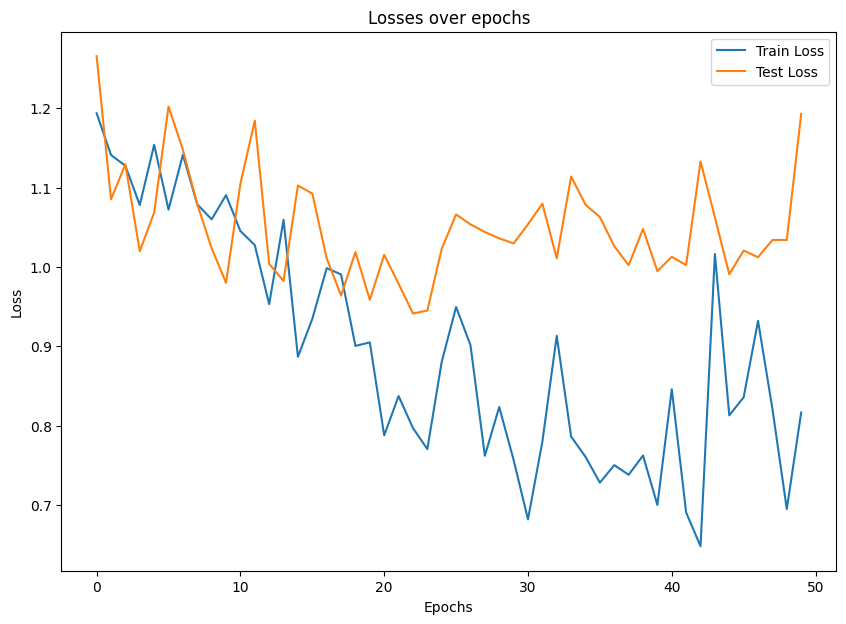

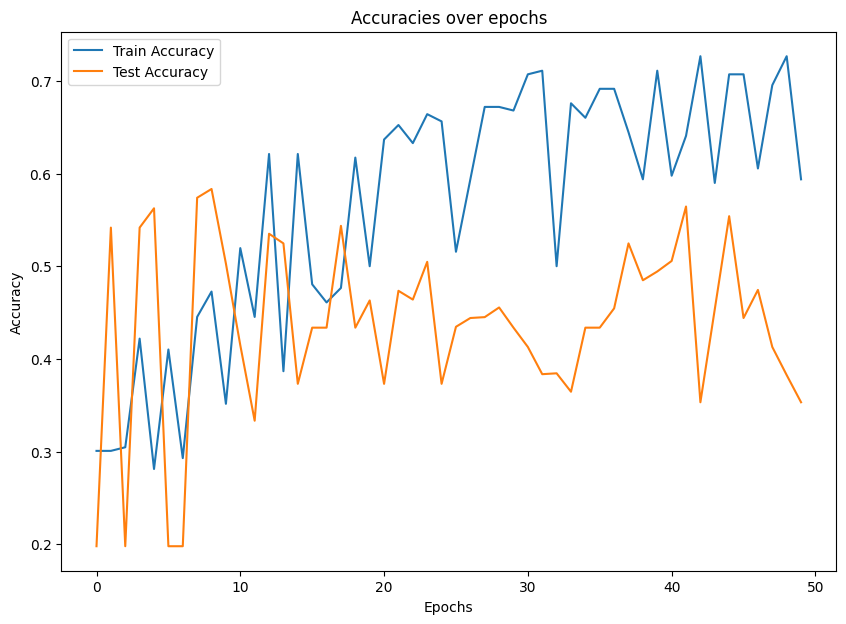

In [81]:
plot_losses(model_0_results["train_loss"], model_0_results["test_loss"])
plot_accuracies(model_0_results["train_acc"], model_0_results["test_acc"])

In [84]:
# show some test images and their predictions
import matplotlib.pyplot as plt

def plot_predictions(model: torch.nn.Module,
                     data: torch.utils.data.Dataset,
                     class_names: list,
                     num_images: int = 9) -> None:
    """
    Plots model predictions on a sample of images from a dataset.
    """
    # seed random number generator for reproducibility
    torch.manual_seed(42)
    # Set model to eval mode
    model.eval()
    
    # Get a sample of images and labels
    images, labels = next(iter(DataLoader(data, batch_size=num_images, shuffle=True)))
    
    # Send images to target device
    images = images.to(device)
    
    # Make predictions
    with torch.inference_mode():
        preds = model(images)
        preds = preds.argmax(dim=1)
    
    # Plot the images and predictions
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        plt.title(f"Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis(False)
    plt.tight_layout()
    plt.show()

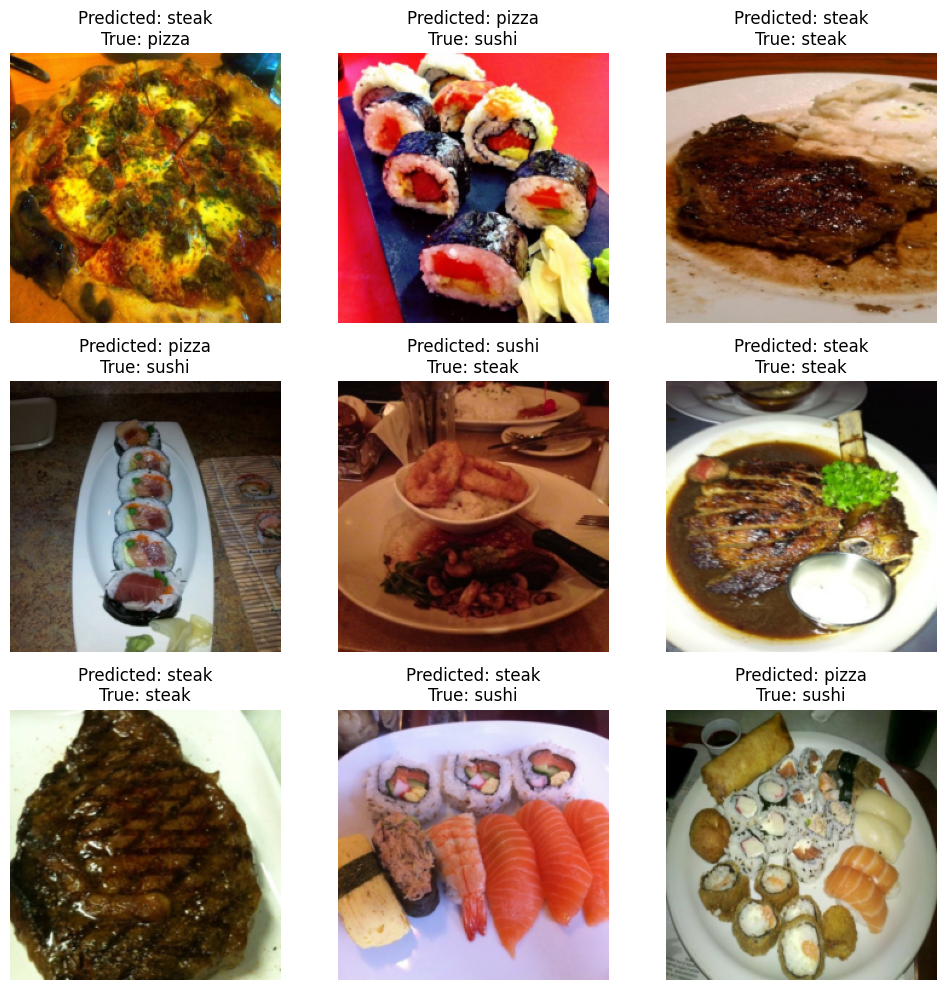

In [85]:
# show the test images and their predictions
plot_predictions(model=model_0,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)

In [83]:
# try a resnet18 model
from torchvision import models
# Create a ResNet18 model
model_1 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
# Change the final layer to match our number of classes
model_1.fc = nn.Linear(in_features=model_1.fc.in_features,
                          out_features=len(train_data.classes)).to(device)

# Retrain the model
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
# Start the timer
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=30)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  3%|▎         | 1/30 [00:01<00:56,  1.95s/it]

Epoch: 1 | train_loss: 1.2043 | train_acc: 0.5898 | test_loss: 6.2276 | test_acc: 0.5559


  7%|▋         | 2/30 [00:03<00:43,  1.57s/it]

Epoch: 2 | train_loss: 0.7417 | train_acc: 0.6680 | test_loss: 16.7403 | test_acc: 0.2500


 10%|█         | 3/30 [00:04<00:39,  1.45s/it]

Epoch: 3 | train_loss: 0.4326 | train_acc: 0.8789 | test_loss: 1.5607 | test_acc: 0.8646


 13%|█▎        | 4/30 [00:05<00:36,  1.39s/it]

Epoch: 4 | train_loss: 0.6562 | train_acc: 0.7305 | test_loss: 0.7687 | test_acc: 0.7225


 17%|█▋        | 5/30 [00:07<00:34,  1.39s/it]

Epoch: 5 | train_loss: 0.3069 | train_acc: 0.9297 | test_loss: 2.5729 | test_acc: 0.5180


 20%|██        | 6/30 [00:08<00:33,  1.38s/it]

Epoch: 6 | train_loss: 0.5131 | train_acc: 0.7656 | test_loss: 1.2030 | test_acc: 0.6515


 23%|██▎       | 7/30 [00:09<00:31,  1.35s/it]

Epoch: 7 | train_loss: 0.3659 | train_acc: 0.8906 | test_loss: 2.0277 | test_acc: 0.5076


 27%|██▋       | 8/30 [00:11<00:29,  1.35s/it]

Epoch: 8 | train_loss: 0.3564 | train_acc: 0.8125 | test_loss: 0.3181 | test_acc: 0.9062


 30%|███       | 9/30 [00:12<00:28,  1.34s/it]

Epoch: 9 | train_loss: 0.6582 | train_acc: 0.8008 | test_loss: 1.1209 | test_acc: 0.6297


 33%|███▎      | 10/30 [00:13<00:26,  1.33s/it]

Epoch: 10 | train_loss: 0.3691 | train_acc: 0.8086 | test_loss: 0.4621 | test_acc: 0.8456


 37%|███▋      | 11/30 [00:15<00:24,  1.32s/it]

Epoch: 11 | train_loss: 0.1935 | train_acc: 0.9336 | test_loss: 1.0459 | test_acc: 0.8229


 40%|████      | 12/30 [00:16<00:23,  1.32s/it]

Epoch: 12 | train_loss: 0.5903 | train_acc: 0.8203 | test_loss: 0.4272 | test_acc: 0.8958


 43%|████▎     | 13/30 [00:17<00:22,  1.33s/it]

Epoch: 13 | train_loss: 0.2668 | train_acc: 0.8203 | test_loss: 2.2297 | test_acc: 0.4138


 47%|████▋     | 14/30 [00:19<00:21,  1.34s/it]

Epoch: 14 | train_loss: 0.2509 | train_acc: 0.9180 | test_loss: 0.7593 | test_acc: 0.7330


 50%|█████     | 15/30 [00:20<00:20,  1.35s/it]

Epoch: 15 | train_loss: 0.5672 | train_acc: 0.7891 | test_loss: 1.7194 | test_acc: 0.5578


 53%|█████▎    | 16/30 [00:21<00:18,  1.34s/it]

Epoch: 16 | train_loss: 0.3824 | train_acc: 0.7773 | test_loss: 1.2608 | test_acc: 0.6922


 57%|█████▋    | 17/30 [00:23<00:17,  1.34s/it]

Epoch: 17 | train_loss: 0.4637 | train_acc: 0.8008 | test_loss: 0.7682 | test_acc: 0.7225


 60%|██████    | 18/30 [00:24<00:16,  1.34s/it]

Epoch: 18 | train_loss: 0.5725 | train_acc: 0.7617 | test_loss: 1.0239 | test_acc: 0.7917


 63%|██████▎   | 19/30 [00:25<00:14,  1.33s/it]

Epoch: 19 | train_loss: 0.3171 | train_acc: 0.8125 | test_loss: 0.4787 | test_acc: 0.8248


 67%|██████▋   | 20/30 [00:27<00:13,  1.33s/it]

Epoch: 20 | train_loss: 0.4189 | train_acc: 0.8203 | test_loss: 0.6152 | test_acc: 0.7547


 70%|███████   | 21/30 [00:28<00:12,  1.34s/it]

Epoch: 21 | train_loss: 0.2483 | train_acc: 0.8398 | test_loss: 0.7528 | test_acc: 0.6932


 73%|███████▎  | 22/30 [00:29<00:10,  1.33s/it]

Epoch: 22 | train_loss: 0.5160 | train_acc: 0.8086 | test_loss: 0.4555 | test_acc: 0.8040


 77%|███████▋  | 23/30 [00:31<00:09,  1.32s/it]

Epoch: 23 | train_loss: 0.2739 | train_acc: 0.8203 | test_loss: 0.3229 | test_acc: 0.8864


 80%|████████  | 24/30 [00:32<00:07,  1.32s/it]

Epoch: 24 | train_loss: 0.3433 | train_acc: 0.8594 | test_loss: 0.3311 | test_acc: 0.9167


 83%|████████▎ | 25/30 [00:33<00:06,  1.32s/it]

Epoch: 25 | train_loss: 0.4470 | train_acc: 0.8203 | test_loss: 1.3439 | test_acc: 0.5994


 87%|████████▋ | 26/30 [00:35<00:05,  1.31s/it]

Epoch: 26 | train_loss: 0.1991 | train_acc: 0.8516 | test_loss: 0.2522 | test_acc: 0.9271


 90%|█████████ | 27/30 [00:36<00:03,  1.32s/it]

Epoch: 27 | train_loss: 0.4491 | train_acc: 0.8125 | test_loss: 0.4434 | test_acc: 0.8153


 93%|█████████▎| 28/30 [00:37<00:02,  1.32s/it]

Epoch: 28 | train_loss: 0.4426 | train_acc: 0.8242 | test_loss: 1.1397 | test_acc: 0.6809


 97%|█████████▋| 29/30 [00:39<00:01,  1.32s/it]

Epoch: 29 | train_loss: 0.2718 | train_acc: 0.9258 | test_loss: 0.3811 | test_acc: 0.8655


100%|██████████| 30/30 [00:40<00:00,  1.35s/it]

Epoch: 30 | train_loss: 0.3691 | train_acc: 0.8320 | test_loss: 0.3739 | test_acc: 0.9062
Total training time: 40.442 seconds


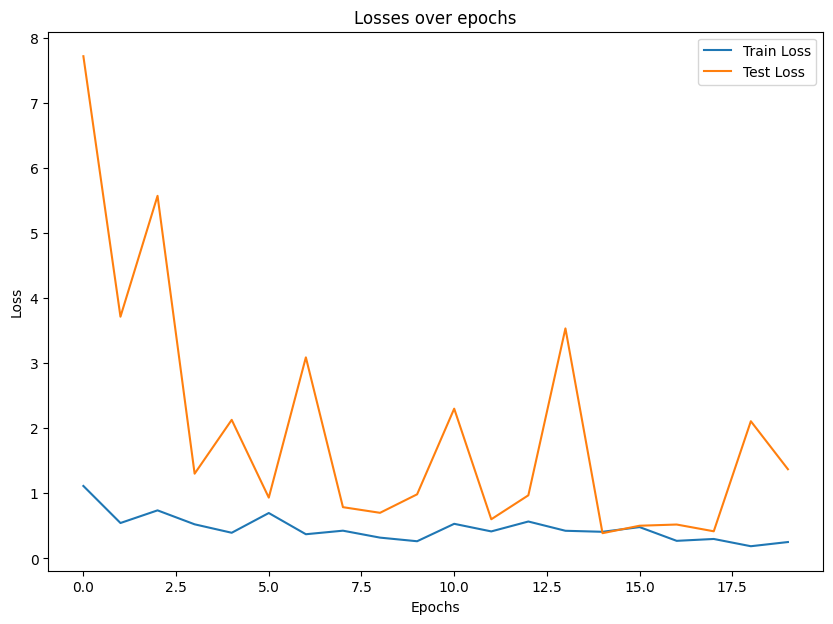

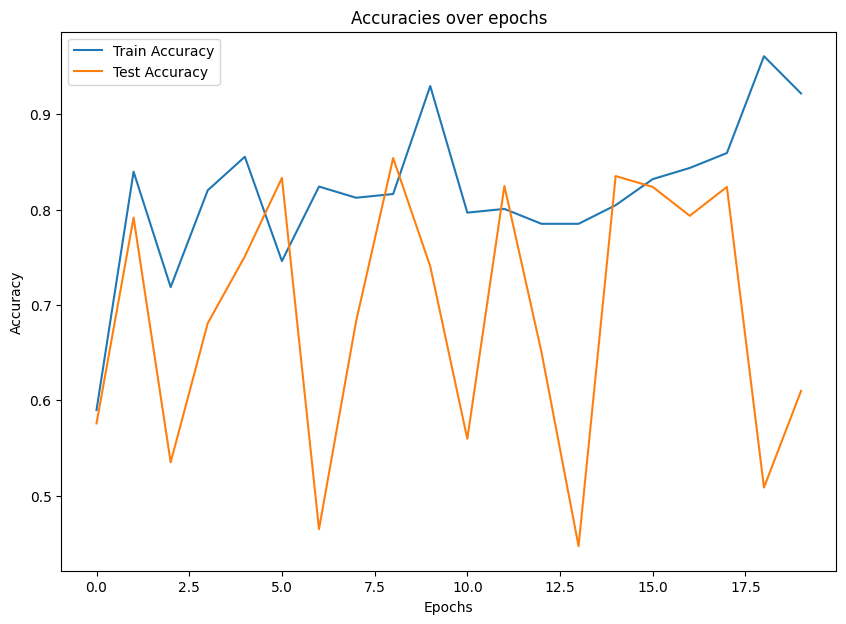

In [82]:
plot_losses(model_1_results["train_loss"], model_1_results["test_loss"])
plot_accuracies(model_1_results["train_acc"], model_1_results["test_acc"])

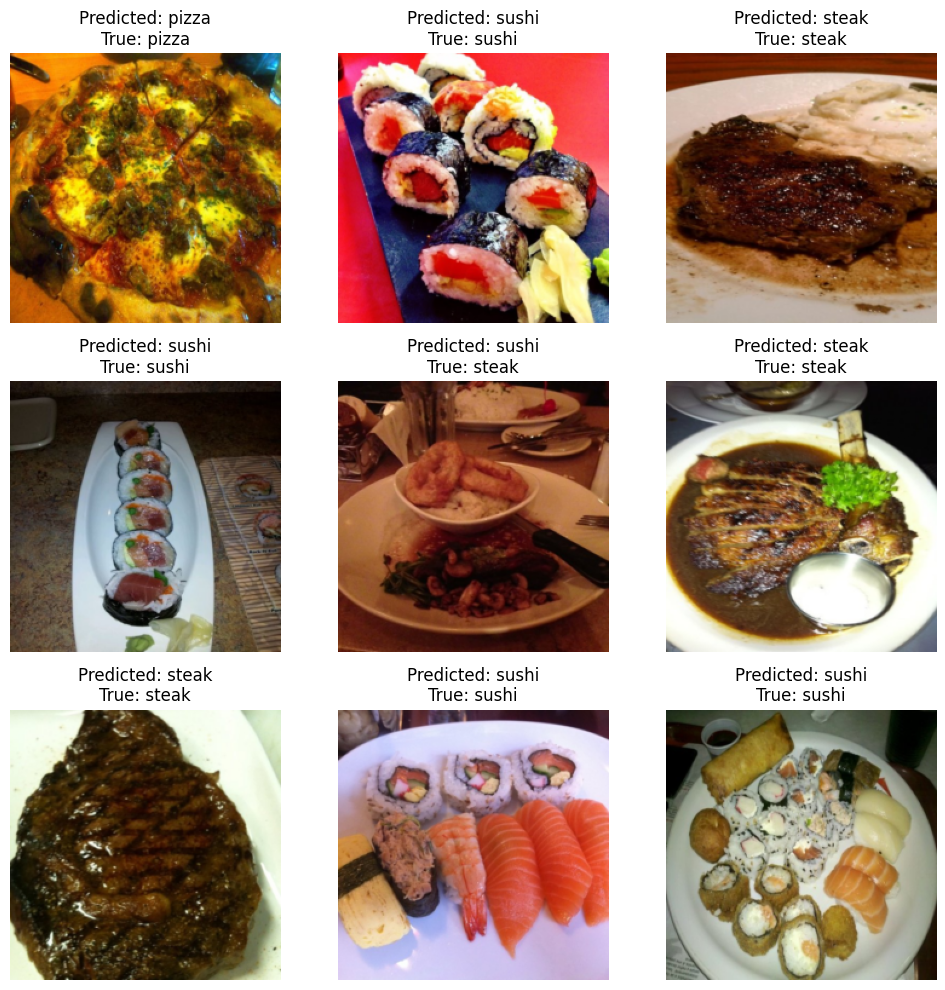

In [86]:
# Plot predictions on test data
plot_predictions(model=model_1,
                 data=test_data,
                 class_names=test_data.classes,
                 num_images=9)